In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, TimeDistributed, ConvLSTM2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pickle
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
      data = load_file(prefix + name)
      loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
  
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    valX = testX[:1500]
    valy = testy[:1500]
    testX = testX[1500:]
    testy = testy[1500:]
    print(trainX.shape, trainy.shape, testX.shape, testy.shape, valX.shape, valy.shape)
    return trainX, trainy, testX, testy, valX, valy

In [3]:
trainX, trainy, testX, testy, valX, valy = load_dataset("/content/drive/MyDrive/ConvLSTM-Responsibility/")

FileNotFoundError: ignored

In [ ]:
# Define model
def build_model(n_timesteps, n_features, num_classes, n_steps, n_length):
  # define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(num_classes, activation='softmax'))

	return model
 
def mini_batches(X, Y, mini_batch_size=1):
    # Generate batches

    m = X.shape[0]  # number of training examples
    mini_batches = []

    # Step 1: Shuffle (X, Y)
    # permutation = list(np.random.permutation(m))
    # shuffled_X = X[permutation, :, :, :]
    # shuffled_Y = Y[permutation, :, :, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(
        np.floor(m / mini_batch_size))  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X[num_complete_minibatches * mini_batch_size: m, :, :, :]
        mini_batch_Y = Y[num_complete_minibatches * mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches
 


In [ ]:
def train(args): 

  batch_size = args["batch_size"]
  verbose = args["verbose"]
  epochs = args["epochs"]
  n_timesteps = args["n_timesteps"]
  n_features = args["n_features"]
  n_steps = args["n_steps"]
  n_length = args["n_length"]
  num_classes = args["num_classes"]
  learning_rate = args['learning_rate']

  x_train = args["x_train"] 
  y_train = args["y_train"] 
  x_val = args["x_val"] 
  y_val = args["y_val"] 
  
  # reshape into subsequences (samples, time steps, rows, cols, channels)
  x_train = x_train.reshape((x_train.shape[0], n_steps, 1, n_length, n_features))
  x_val = x_val.reshape((x_val.shape[0], n_steps, 1, n_length, n_features))
 
  num_samples = (x_train.shape)[0]
  num_minibatches = int(np.ceil(num_samples / batch_size))
  total_delta_weights = [0] * num_samples
  print("Number of MiniBatches:", num_minibatches)
  # with strategy.scope():
  model = build_model(n_timesteps, n_features, num_classes, n_steps, n_length)
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  # plot_model(model, to_file="/content/drive/MyDrive/cifar10alexnet/New_Dataset/" + model_type + ".png", show_shapes=True, show_layer_names=True)
  
  for epoch in range(epochs):
    num_minibatches = int(num_samples / batch_size)
    minibatches = mini_batches(x_train, y_train, batch_size)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print("---------------------------------------------------", "Epoch:", epoch+1, "-----------------------------------------------------------------------")
  
    counter = 0
    count = 0

    for minibatch in minibatches:
        
        (train_sample_x, train_sample_y) = minibatch

        pre_weights = np.array(model.layers[-1].get_weights()[0])

        counter += 1

        model.fit(train_sample_x, train_sample_y,
                  batch_size=batch_size,
                  # steps_per_epoch=train_sample_x.shape[0] // batch_size,
                  shuffle=False, 
                  epochs=1,
                  # validation_data=(x_val, y_val),
                  # callbacks=[reduce_lr],
                  verbose=0)

        post_weights = np.array(model.layers[-1].get_weights()[0])
        delta_weights = np.subtract(post_weights, pre_weights)

        for i in range(len(train_sample_x)):
            total_delta_weights[i + count] = np.add(total_delta_weights[i + count], delta_weights)

        count += len(train_sample_x)
    
    print("Train Scores:")
    tr_loss, tr_acc = model.evaluate(x=x_train, y=y_train, verbose=verbose)
    print("Test Scores:")
    val_loss, val_acc = model.evaluate(x=x_val, y=y_val, verbose=verbose) 

  return model, total_delta_weights

In [ ]:
my_args = {"batch_size": 1,
"epochs": 10,
"verbose": 1,
"n_timesteps": trainX.shape[1],
"n_features": trainX.shape[2],
"n_steps": 4,
"n_length": 32,
"num_classes": trainy.shape[1],
'learning_rate': 0.001,
"x_train": trainX, 
"y_train": trainy,
"x_val": valX,
"y_val": valy,
}

#  random.seed(73)
model, total_delta_weights = train(my_args)

Number of MiniBatches: 7352
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 30, 64)         56320     
_________________________________________________________________
dropout (Dropout)            (None, 1, 30, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               192100    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 249,026
Trainable params: 249,026
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------- Epoch: 1 ---------------------------

In [ ]:
model.save_weights('/content/drive/MyDrive/ConvLSTM-Responsibility/model_1.h5')
pickle.dump(total_delta_weights, open("/content/drive/MyDrive/ConvLSTM-Responsibility/total_delta_weights.pickle", "wb"))

# Responsibility

In [ ]:
def responsibility(total_delta_weights):
  arr = np.array(total_delta_weights, dtype=np.float16)
  print("Layer delta weights:", arr.shape)
  print("----------------------------------------------------------------------")

  argmax_array = np.argmax(arr, axis=0)
  print("Most Responsible Positive Array ---- Shape:", argmax_array.shape)
  counts_max = np.bincount(argmax_array.flatten())
  print("Most Frequent Index:", counts_max.argsort()[-10:][::-1])
  print("----------------------------------------------------------------------")


  pickle.dump(argmax_array, open("/content/drive/MyDrive/AlexNetCifar10/array_of_IDs_of_positive_most_responsible_samples.pickle", "wb"))

  return argmax_array

In [ ]:
array_of_IDs_of_positive_most_responsible_samples = responsibility(total_delta_weights)

Layer delta weights: (7352, 100, 6)
----------------------------------------------------------------------
Most Responsible Positive Array ---- Shape: (100, 6)
Most Frequent Index: [6330 4060 5517 5246 2305 4137 5516 2551 1436 2550]
----------------------------------------------------------------------


In [ ]:
def shuffle_in_unison(a, b, c, d):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)
    np.random.set_state(rng_state)
    np.random.shuffle(d)

    return a, b, c, d

# Generating tuples for the second model

## Training Tuples

In [ ]:
# Generating Data for Model 2
print("Validation shape:", valX.shape)
n_steps, n_length, n_features = 4, 32, trainX.shape[2]
valX = valX.reshape((valX.shape[0], n_steps, 1, n_length, n_features))
print("Validation shape after reshape:", valX.shape)
predicted_y = model.predict(valX, batch_size=1)
residuals = np.argmax(predicted_y,1)!=np.argmax(valy,1)
loss = sum(residuals)/len(residuals)
print("The Test 0/1 loss is: ", loss)

print("Number of Incorrect samples:", sum(residuals))

Validation shape: (1500, 128, 9)
Validation shape after reshape: (1500, 4, 1, 32, 9)
The Test 0/1 loss is:  0.196
Number of Incorrect samples: 294


In [ ]:
# Generating Data for Model 2
print("Training shape:", trainX.shape)
n_steps, n_length, n_features = 4, 32, trainX.shape[2]
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
print("Training shape after reshape:", trainX.shape)
predicted_y_tr = model.predict(trainX, batch_size=1)
residuals_tr = np.argmax(predicted_y_tr,1)!=np.argmax(trainy,1)
loss_tr = sum(residuals_tr)/len(residuals_tr)
print("The Train 0/1 loss is: ", loss_tr)

print("Number of Incorrect samples:", sum(residuals_tr))

Validation shape: (7352, 128, 9)
Validation shape after reshape: (7352, 4, 1, 32, 9)
The Train 0/1 loss is:  0.08120239390642002
Number of Incorrect samples: 597


In [ ]:
# Final Data for the Second Model 

incorrect_indecies = list([i for i, x in enumerate(residuals) if x])
correct_indecies = [a for a in range(valX.shape[0]) if a not in incorrect_indecies]

print(len(incorrect_indecies), "+", len(correct_indecies), "=", len(valX))


incorrect_samples = []
incorrect_x = []
incorrect_y = []
incorrect_y_true = []
incorrect_y_pred = []
for ind in incorrect_indecies:
  incorrect_x.append(valX[ind])
  incorrect_y.append(0.0)
  incorrect_y_true.append(valy[ind])
  incorrect_y_pred.append(predicted_y[ind])

incorrect_indecies_tr = list([i for i, x in enumerate(residuals_tr) if x])
correct_indecies_tr = [a for a in range(trainX.shape[0]) if a not in incorrect_indecies_tr]

for ind_tr in incorrect_indecies_tr:
  incorrect_x.append(trainX[ind_tr])
  incorrect_y.append(0.0)
  incorrect_y_true.append(trainy[ind_tr])
  incorrect_y_pred.append(predicted_y_tr[ind_tr])

print("Incorrects Done! - Length =", len(incorrect_x))

294 + 1206 = 1500
Incorrects Done! - Length = 891


In [ ]:
correct_indecies = random.sample(correct_indecies_tr, len(incorrect_x))

correct_samples = []
correct_x = []
correct_y = []
correct_y_true = []
correct_y_pred = []
for ind in correct_indecies:
  correct_x.append(trainX[ind])
  correct_y.append(1.0)
  correct_y_true.append(trainy[ind])
  correct_y_pred.append(predicted_y_tr[ind])

print("Corrects Done! - Length =", len(correct_x))

Corrects Done! - Length = 891


In [ ]:
x_train_list = correct_x + incorrect_x
y_train_list = correct_y + incorrect_y
y_true_list = correct_y_true + incorrect_y_true
y_pred_list = correct_y_pred + incorrect_y_pred

final_x_train = np.array(x_train_list)
final_y_train = np.array(y_train_list)
final_y_true = np.array(y_true_list)
final_y_pred = np.array(y_pred_list)

final_x_train, final_y_train, final_y_true, final_y_pred = shuffle_in_unison(final_x_train, final_y_train, final_y_true, final_y_pred)

print("Final X and Y Shape:", final_x_train.shape, final_y_train.shape, final_y_true.shape, final_y_pred.shape)

Final X and Y Shape: (1782, 4, 1, 32, 9) (1782,) (1782, 6) (1782, 6)


In [ ]:
def finding_resp_samples_wx_method(sample, model, ind_array_fc_pos, training_samples):
  inp = model.input  # input placeholder
  outputs = [layer.output for layer in model.layers]  # all layer outputs
  functor = K.function([inp], outputs)  # evaluation function
  sample = np.reshape(sample, (1,n_steps,1,n_length,n_features))
  layer_outs = functor([sample])
  # conv_out = layer_outs[0].reshape((32, 32, 64))
  dense_out = layer_outs[-1]
  dense_in = layer_outs[-2].reshape((100,))

  # print(conv1_out.shape)
  # print(dense2_out.shape)

  max_ind_fc = np.argmax(dense_out)

  fc_layer_weights = np.array(model.layers[-1].get_weights()[0])

  max_weights = fc_layer_weights[:, max_ind_fc]


  w = []
  x = []
  wx = []
  for i in range(len(max_weights)):
    w.append(max_weights[i])
    x.append(dense_in[i])
    wx.append(max_weights[i] * dense_in[i])


  pos_most_resp_1 = training_samples[ind_array_fc_pos[np.argmax(wx), max_ind_fc]]

  return pos_most_resp_1, wx
  

In [ ]:
XY_tuples = []
for i in range(len(final_x_train)):
# for j in range(1):
    # i = random.randint(0,len(final_x_train))
    sample = final_x_train[i]
    prediction = final_y_train[i]
    y_truee = final_y_true[i]
    y_pred = final_y_pred[i]

    # print("y true:", y_truee)
    # print("ypred:", y_pred)
    # print("prediction:", prediction)

    pos_most_resp_1, wx = finding_resp_samples_wx_method(
          sample, model,
          array_of_IDs_of_positive_most_responsible_samples,
          trainX)
    # print(responsible_IDs)
    XY_tuples.append((sample, pos_most_resp_1, prediction, y_truee, y_pred, wx))


In [ ]:
len(XY_tuples)

1782

In [ ]:
pickle.dump(XY_tuples, open("/content/drive/MyDrive/ConvLSTM-Responsibility/tuples_for_model2.pickle","wb"))

## Testing Tuples (Unseen)

In [ ]:
# Generating Data for Model 2
print("Test shape:", testX.shape)
n_steps, n_length, n_features = 4, 32, testX.shape[2]
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
print("Test shape after reshape:", testX.shape)
predicted_y_un = model.predict(testX, batch_size=1)
residuals_un = np.argmax(predicted_y_un,1)!=np.argmax(testy,1)
loss_un = sum(residuals_un)/len(residuals_un)
print("The Test 0/1 loss is: ", loss_un)

print("Number of Incorrect samples:", sum(residuals_un))

Test shape: (1447, 128, 9)
Test shape after reshape: (1447, 4, 1, 32, 9)
The Test 0/1 loss is:  0.08500345542501728
Number of Incorrect samples: 123


In [ ]:
# Generating Data for Model 2

incorrect_indecies = list([i for i, x in enumerate(residuals_un) if x])
correct_indecies = [a for a in range(testX.shape[0]) if a not in incorrect_indecies]

print(len(incorrect_indecies), "+", len(correct_indecies), "=", len(testX))


# correct_indecies = random.sample(correct_indecies, len(incorrect_indecies))

incorrect_samples = []
incorrect_x = []
incorrect_y = []
incorrect_y_true = []
incorrect_y_pred = []
for ind in incorrect_indecies:
  incorrect_x.append(testX[ind])
  incorrect_y.append(0.0)
  incorrect_y_true.append(testy[ind])
  incorrect_y_pred.append(predicted_y_un[ind])



correct_samples = []
correct_x = []
correct_y = []
correct_y_true = []
correct_y_pred = []
for ind in correct_indecies:
  correct_x.append(testX[ind])
  correct_y.append(1.0)
  correct_y_true.append(testy[ind])
  correct_y_pred.append(predicted_y_un[ind])

x_train_list = correct_x + incorrect_x
y_train_list = correct_y + incorrect_y
y_true_list = correct_y_true + incorrect_y_true
y_pred_list = correct_y_pred + incorrect_y_pred

final_x_train = np.array(x_train_list)
final_y_train = np.array(y_train_list)
final_y_true = np.array(y_true_list)
final_y_pred = np.array(y_pred_list)

final_x_train, final_y_train, final_y_true, final_y_pred = shuffle_in_unison(final_x_train, final_y_train, final_y_true, final_y_pred)

print("Final X and Y Shape:", final_x_train.shape, final_y_train.shape, final_y_true.shape, final_y_pred.shape)

123 + 1324 = 1447
Final X and Y Shape: (1447, 4, 1, 32, 9) (1447,) (1447, 6) (1447, 6)


In [ ]:
XY_tuples = []
for i in range(len(final_x_train)):
# for j in range(1):
    # i = random.randint(0,len(final_x_train))
    sample = final_x_train[i]
    prediction = final_y_train[i]
    y_truee = final_y_true[i]
    y_pred = final_y_pred[i]

    # print("y true:", y_truee)
    # print("ypred:", y_pred)
    # print("prediction:", prediction)

    pos_most_resp_1, wx = finding_resp_samples_wx_method(
          sample, model,
          array_of_IDs_of_positive_most_responsible_samples,
          trainX)
    # print(responsible_IDs)
    XY_tuples.append((sample, pos_most_resp_1, prediction, y_truee, y_pred, wx))


In [ ]:
len(XY_tuples)

1447

In [ ]:
pickle.dump(XY_tuples, open("/content/drive/MyDrive/ConvLSTM-Responsibility/tuples_unseen.pickle","wb"))

# Model 2

In [ ]:
train_tuples = pickle.load(open("/content/drive/MyDrive/ConvLSTM-Responsibility/tuples_for_model2.pickle", "rb"))
unseen_tuples = pickle.load(open("/content/drive/MyDrive/ConvLSTM-Responsibility/tuples_unseen.pickle", "rb"))

In [ ]:
print(len(unseen_tuples), len(train_tuples))

1447 1782


In [ ]:
# What's inside the tuples: [sample, pos_most_resp_1, prediction, y_truee, y_pred, wx]

In [ ]:
def preprocess_data(train_tuples, unseen_tuples):

  samples = []
  resp_samples = []
  y = []
  y_trues = []
  y_preds = []
  for tpl in train_tuples:
    samples.append(tpl[0])
    resp_samples.append(tpl[1])
    y_trues.append(tpl[3])
    y_preds.append(tpl[4])

    if tpl[2] == 0:
      y.append([1.0,0.0])
    elif tpl[2] == 1:
      y.append([0.0,1.0])

  unseen_samples = []
  unseen_resp_samples = []
  unseen_y = []
  unseen_y_trues = []
  unseen_y_preds = []
  for unseen_tpl in unseen_tuples:
    unseen_samples.append(unseen_tpl[0])
    unseen_resp_samples.append(unseen_tpl[1])
    unseen_y_trues.append(unseen_tpl[3])
    unseen_y_preds.append(unseen_tpl[4])

    if unseen_tpl[2] == 0:
      unseen_y.append([1.0,0.0])
    elif unseen_tpl[2] == 1:
      unseen_y.append([0.0,1.0])

 
  samples = np.array(samples)
  resp_samples = np.array(resp_samples)

  unseen_samples = np.array(unseen_samples)
  unseen_resp_samples = np.array(unseen_resp_samples)

  y = np.array(y)
  unseen_y = np.array(unseen_y)



  print('Training Data:')
  print("Input Shapes:", samples.shape, resp_samples.shape)
  print("Output shape:", y.shape)

  print('Unseen Data:')
  print("Input Image Shapes:", unseen_samples.shape, unseen_resp_samples.shape)
  print("Output shape:", unseen_y.shape)
  return samples, resp_samples, y, y_trues, y_preds, unseen_samples, unseen_resp_samples, unseen_y, unseen_y_trues, unseen_y_preds

In [ ]:
samples, resp_samples, y, y_trues, y_preds, samples_unseen, resp_samples_unseen, y_unseen, y_trues_unseen, y_preds_unseen = preprocess_data(train_tuples, unseen_tuples)

Training Data:
Input Shapes: (1782, 4, 1, 32, 9) (1782, 4, 1, 32, 9)
Output shape: (1782, 2)
Unseen Data:
Input Image Shapes: (1447, 4, 1, 32, 9) (1447, 4, 1, 32, 9)
Output shape: (1447, 2)


In [ ]:
def train_model_2(args): 
  batch_size = args["batch_size"]
  maxepoch = args["maxepoches"]
  num_classes = args["num_classes"]

  min_lr = args["min_lr"]
  max_lr = args["max_lr"]
  optimizer = args["optimizer"]

  n_timesteps = args["n_timesteps"]
  n_features = args["n_features"]
  n_steps = args["n_steps"]
  n_length = args["n_length"]


  train_samples = args["train_samples"]
  test_samples = args["test_samples"]
  train_resps = args["train_resps"]
  test_resps = args["test_resps"]
  y_train = args["y_train"]
  y_test = args["y_test"]

  model = None

  def lr_scheduler(epoch):
      if epoch <= 0.6 * maxepoch:
        learning_rate = max_lr
      else:
        learning_rate = max_lr + ((epoch + 1 - (0.6 * maxepoch)) * (min_lr - max_lr) / (0.4 * maxepoch) )
      print("Epoch:", epoch, "Learning Rate:", learning_rate)
      return learning_rate

  model = build_model(n_timesteps, n_features, num_classes, n_steps, n_length)
  reduce_lr = callbacks.LearningRateScheduler(lr_scheduler)
  if optimizer == "sgd":
    opt = optimizers.SGD(learning_rate=min_lr, momentum=0.9, nesterov=True)
  elif optimizer == "adam":
    opt = optimizers.Adam(learning_rate=min_lr)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  # plot_model(model, to_file="/content/drive/MyDrive/Responsibility_Comparison/New_Dataset/" + model_type + ".png", show_shapes=True, show_layer_names=True)

  x_train = np.concatenate((train_samples, train_resps), axis=4)
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    # steps_per_epoch=samples.shape[0] // batch_size,
                    shuffle=True, 
                    epochs=maxepoch,
                    validation_split=0.2,
                    callbacks=[reduce_lr],
                    verbose=1)
  
  # x_test = np.concatenate((test_samples, test_resps), axis=3)
  # print("Evaluation on Testset:")
  # model.evaluate(x_test, y_test)
  # y_hat = model.predict(x_test)

  # y_pred = np.argmax(y_hat, axis=1)
  # y_true = np.argmax(y_test, axis=1)

  # my_precision = precision_score(y_true, y_pred)
  # my_recal = recall_score(y_true, y_pred)
  # my_f1 = f1_score(y_true, y_pred)
  # print("Precision:", my_precision, "Recall:", my_recal, "f1 score:", my_f1)

  return model, history

In [ ]:
my_args = {"batch_size": 32,
"maxepoches": 50,

"min_lr": 0.00001,
"max_lr": 0.001,
"optimizer": "adam", # different optimizers: adam, sgd

"n_timesteps": 128,
"n_features": samples.shape[4] + resp_samples.shape[4],
"n_steps": 4,
"n_length": 32,
"num_classes": y.shape[1],

"train_samples": samples, 
"test_samples": samples_unseen,
"train_resps": resp_samples,
"test_resps": resp_samples_unseen,
"y_train": y,
"y_test": y_unseen
}

model_2, hist = train_model_2(my_args)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 30, 64)         63232     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               192100    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 255,534
Trainable params: 255,534
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
Epoch: 0 Learning Rate: 0.001
45/45 [==============================] - 18s 28ms/step - loss: 0.6146 - a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


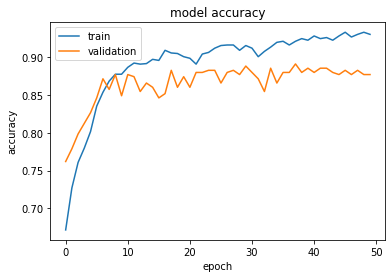

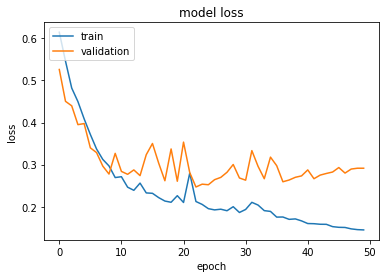

In [ ]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
print("Evaluation on Unseen Dataset:")

x_test = np.concatenate((samples_unseen, resp_samples_unseen), axis=4)
print(x_test.shape)

model_2.evaluate(x_test, y_unseen)
y_hat = model_2.predict(x_test)

y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_unseen, axis=1)

my_precision = precision_score(y_true, y_pred)
my_recal = recall_score(y_true, y_pred)
my_f1 = f1_score(y_true, y_pred)
print("Precision:", my_precision, "Recall:", my_recal, "f1 score:", my_f1)

Evaluation on Unseen Dataset:
(1447, 4, 1, 32, 18)
46/46 [==============================] - 0s 4ms/step - loss: 0.4573 - accuracy: 0.9026
Precision: 0.9766317485898469 Recall: 0.9154078549848943 f1 score: 0.9450292397660819


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[  94,   29],
       [ 112, 1212]])

## Generating new predictions for the first model, using the second model:

In [ ]:
test_preds_new = []
for i in range(len(x_test)):
  if y_pred[i] == 0:
    # print("According to the second model, test sample number", i, "is an incorrect prediction by the initial model")
    # print(
    #     # "In reality, this is a\an", 
    #       ["incorrect", "correct"][y_true[i]], 
    #       # "prediction by model 1"
    #       )
    test_preds_new.append(np.argsort(y_preds_unseen[i], axis=0)[-2])
  else:
    test_preds_new.append(np.argmax(y_preds_unseen[i]))


In [ ]:
print("The accuracy of the first model on unseen data:", sklearn.metrics.accuracy_score(np.argmax(y_trues_unseen, axis=1), np.argmax(y_preds_unseen, axis=1)))

0.9149965445749827

In [ ]:
print("The accuracy of the first model on unseen data, after changing its predictions using the second model:", sklearn.metrics.accuracy_score(np.argmax(y_trues_unseen, axis=1), np.array(test_preds_new)))

0.8887353144436766

We can definetely work on improving the accuracy using the second model, since currently the results are not too much lower than the original accuracy. 

In [ ]:
model_2.save_weights('/content/drive/MyDrive/ConvLSTM-Responsibility/model_2.h5')